In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import folium
from folium import plugins, FeatureGroup
import branca.colormap as cm
from palettable.colorbrewer.sequential import YlGnBu_5

%matplotlib inline

## ▸ Exercise: Package installation
___
- Some additional packages will need to be installed. 
- Install is left as an exercise

In [4]:
df = pd.read_csv('data/drifters-ictp.csv')
df.head()

,id,time,gwaddr,modulation,datarate,snr,rssi,freq,lat,lon
0,4925375,2018-03-22 09:30:22,B827EBFFFEBFBEE2,LORA,SF7BW125,-7.0,-117.0,867.9,45.707307,13.713610
1,4925459,2018-03-22 09:32:03,B827EBFFFEBFBEE2,LORA,SF7BW125,-7.0,-119.0,867.1,45.707489,13.713030
2,4925500,2018-03-22 09:32:38,B827EBFFFEBFBEE2,LORA,SF7BW125,-1.8,-118.0,867.1,45.707457,13.711807
3,4925549,2018-03-22 09:33:46,B827EBFFFEBFBEE2,LORA,SF7BW125,-1.8,-114.0,868.5,45.706910,13.709383
4,4925579,2018-03-22 09:34:20,B827EBFFFEBFBEE2,LORA,SF7BW125,8.0,-100.0,867.9,45.706019,13.707730


In [5]:
df.describe()

,id,snr,rssi,freq,lat,lon
count,3.990000e+02,399.000000,399.000000,399.000000,399.000000,399.000000
mean,4.929543e+06,1.586717,-110.927318,867.819298,45.707198,13.704973
std,2.854998e+03,5.120326,5.322016,0.465712,0.004776,0.003755
min,4.925375e+06,-8.800000,-119.000000,867.100000,45.700558,13.700049
25%,4.927098e+06,-3.200000,-115.000000,867.500000,45.701942,13.700778
50%,4.929021e+06,2.200000,-113.000000,867.900000,45.710418,13.707151
75%,4.931736e+06,6.200000,-108.000000,868.300000,45.711469,13.708481
max,4.935073e+06,10.200000,-95.000000,868.500000,45.713057,13.713610


In [6]:
m = folium.Map(
    location=[45.707307, 13.713610],
    tiles='cartodbpositron',
    zoom_start=15,
    control_scale=True
)

In [7]:
colorscale = cm.linear.YlGnBu_09.to_step(data=df['rssi'], n=5, method='linear')
colorscale.caption = 'RSSI (in dB)'

In [8]:
feature_group = FeatureGroup(name='RSSI')

for index, row in df.iterrows():
    folium.features.Circle(
        radius = 25,
        location = [row['lat'], row['lon']],
        popup = str(row['rssi']),
        fill_opacity = 0.5,
        fill_color = colorscale(row['rssi']),
        color = None,
        fill = True).add_to(feature_group)

In [9]:
feature_group.add_to(m)
folium.LayerControl(position='topleft').add_to(m)
colorscale.add_to(m)
m

![img/buoy-1.png](img/buoy-1.png)

### Breaking down Gateways in different feature groups

In [10]:
gateways = df['gwaddr'].value_counts()
gateways

 B827EBFFFEBFBEE2    311
 B827EBFFFEC470BE     88
Name: gwaddr, dtype: int64

In [11]:
m = folium.Map(
    location=[45.707307, 13.713610],
    tiles='cartodbpositron',
    zoom_start=15,
    control_scale=True
)

for gw in list(df['gwaddr'].value_counts().index):
    feature_group = FeatureGroup(name='Gateway:' + gw)
    df_gw = df[df['gwaddr'] == gw]
    
    for index, row in df_gw.iterrows():
        folium.features.Circle(
            radius = 25,
            location = [row['lat'], row['lon']],
            popup = str(row['rssi']),
            fill_opacity = 0.5,
            fill_color = colorscale(row['rssi']),
            color = None,
            fill = True).add_to(feature_group)
    
    feature_group.add_to(m)

In [12]:
folium.LayerControl(position='topleft').add_to(m)
colorscale.add_to(m)
m

### Trying out image overlay with matplotlib hexbin

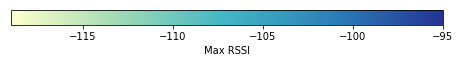

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

hb = ax.hexbin(df.lon, df.lat, C = df.rssi, 
           reduce_C_function = max, gridsize=30, 
           mincnt=0, cmap=YlGnBu_5.get_mpl_colormap(), 
           linewidths=0.5, edgecolors='none')

ax.set_axis_off()

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

plt.savefig('img/buoy-max.png', transparent=True, pad_inches=0, bbox_inches='tight', dpi=300)
plt.close(fig) # do not display default hexbin

# Plot legend
# https://matplotlib.org/examples/api/colorbar_only.html
fig = plt.figure(figsize=(6, 2))
ax1 = fig.add_axes([0, 0, 1, 0.1])
cmap = hb.cmap
norm = mpl.colors.Normalize(vmin=-119, vmax=-95)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal')

cb1.set_label('Max RSSI')

# Save as png and overlay on folium map
data = plt.imread('img/buoy-max.png')

m = folium.Map(
    location=[45.707307, 13.713610],
    tiles='cartodbpositron',
    zoom_start=15,
    control_scale=True
)

m.add_child(plugins.ImageOverlay(data, opacity=0.7, \
        bounds =[[ymin, xmin], [ymax, xmax]]))
m

![buoy-2-overlay.png](img/buoy-2-overlay.png)